In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import pickle
import argparse
import torch
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report
from pathlib import Path
import seaborn as sns
import random
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

sys.path.insert(0, '..')

from config import *
from util.plot_utils import obtain_plot, plot_logs
import util.misc as utils
from train_binary_cl2 import get_args_parser
from models.nt_classifier import build as build_model
from dataset.data import (
    RNADataset,
    RNADatasetNT,
    EasyPosAugment,
    InteractionSelectionPolicy,
    SmartNegAugment,
    seed_everything,
)
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

/data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops10select_int4callERKNS_6TensorEll
  warn(f"Failed to load image Python extension: {e}")


In [3]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'binary_cl2')

In [4]:
# Define the path to the file containing the args namespace
args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)
args.resume = os.path.join(args.output_dir, 'best_model.pth')

In [5]:
file_train = os.path.join(rna_rna_files_dir, "gene_pairs_training_nt.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train = pickle.load(fp)
    
file_test  = os.path.join(rna_rna_files_dir, "gene_pairs_test_nt.txt")
with open(file_test, "rb") as fp:   # Unpickling
    gene_pairs_test = pickle.load(fp)
    
file_val  = os.path.join(rna_rna_files_dir, "gene_pairs_val_nt.txt")
with open(file_val, "rb") as fp:   # Unpickling
    gene_pairs_val = pickle.load(fp)

In [6]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt.csv'))

pos_multipliers = {10_000_000:1.,}
neg_multipliers = pos_multipliers

policies_test = [
    EasyPosAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_multipliers,
        height_multipliers=pos_multipliers,
    ),  
    SmartNegAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=neg_multipliers,
        height_multipliers=neg_multipliers,
    ),
]

dataset_test = RNADatasetNT(
    gene2info=df_genes_nt,
    interactions=df_nt,
    subset_file=file_test,
    augment_policies=policies_test,
    data_dir = os.path.join(embedding_dir, '32'),
    scaling_factor = 5,
    min_n_groups = args.min_n_groups_val,
    max_n_groups = args.max_n_groups_val,
)

sampler_test = torch.utils.data.SequentialSampler(dataset_test)

data_loader_test = DataLoader(dataset_test, 1,
                                     sampler=sampler_test, drop_last=False,
                                     collate_fn=utils.collate_fn_nt2,
                                     num_workers=1)

/tmp/ipykernel_15278/3188623412.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))


In [7]:
device = torch.device('cuda') #torch.device(args.device)
model = build_model(args)
model.to(device)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

/data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


<All keys matched successfully>

In [8]:
start_time = time.time()
model.eval()

probability = []
ground_truth = []
g1 = []
g2 = []
policy = []
len_g1 = []
len_g2 = []
couple_id = []
original_length1 = []
original_length2 = []
ids = []

all_couples = set(df_nt.couples_id)

for (rna1, rna2), target in tqdm(data_loader_test, total = len(data_loader_test) ):
    
    s = target[0]
    interacting = bool(s['interacting'])
    
    row_original = df_nt[(df_nt['gene1'] == s['gene1'])&(df_nt['gene2'] == s['gene2'])]
    row_swapped = df_nt[(df_nt['gene2'] == s['gene1'])&(df_nt['gene1'] == s['gene2'])]
    
    if len(row_original)>0:
        assert len(row_original) == 1
        row = row_original.iloc[0]
    elif len(row_swapped)>0:
        assert len(row_swapped) == 1
        row = row_swapped.iloc[0]
    else:
        raise NotImplementedError

    id_sample = row.couple
    policy_sample = row.policy
    couple_id_sample = row.couples_id
    
    rna1 = rna1.to(device)
    rna2 = rna2.to(device)
    outputs = model(rna1, rna2)
    probability += outputs.softmax(-1)[:, 1].tolist()
    
    ground_truth.append(1 if interacting else 0)
    policy.append(policy_sample)
    couple_id.append(couple_id_sample)
    g1.append(row['gene1'])
    g2.append(row['gene2'])
    len_g1.append(s['bbox'].x2 - s['bbox'].x1)
    len_g2.append(s['bbox'].y2 - s['bbox'].y1)
    # original_length1.append(or_len1)
    # original_length2.append(or_len2)
    ids.append(id_sample)

res = pd.DataFrame({
    'id_sample':ids,
    'probability':probability,
    'ground_truth':ground_truth,
    'g1':g1,
    'g2':g2,
    'policy':policy,
    'len_g1': len_g1,
    'len_g2': len_g2,
    'couples':couple_id,
    # 'original_length1':original_length1,
    # 'original_length2':original_length2
})

res['prediction'] = (res['probability'] > 0.5).astype(int)

(res['prediction'] == res['ground_truth']).sum()/res.shape[0]

res['sampled_area'] = res['len_g1']*res['len_g2']

# res['matrix_area'] = res['original_length1']*res['original_length2']

  0%|          | 0/22979 [00:00<?, ?it/s]

In [9]:
print(classification_report(res.ground_truth, res.prediction))

              precision    recall  f1-score   support

           0       0.59      0.49      0.54     11854
           1       0.54      0.64      0.59     11125

    accuracy                           0.56     22979
   macro avg       0.57      0.57      0.56     22979
weighted avg       0.57      0.56      0.56     22979



# PLOTS

### Log plots

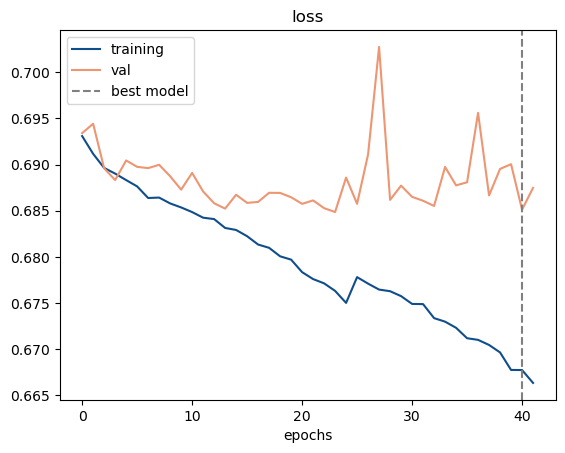

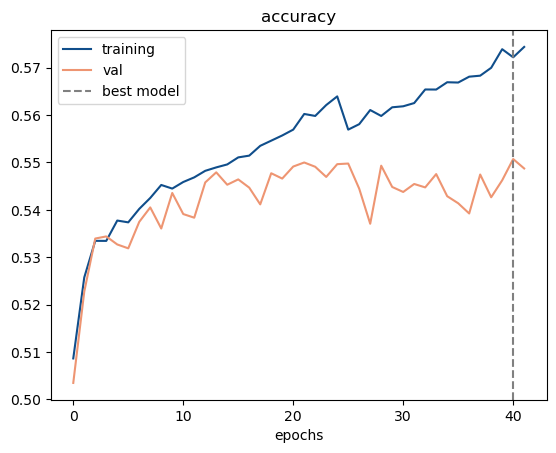

In [10]:
log = pd.read_json(Path(os.path.join(checkpoint_dir, 'log.txt')), lines=True)
best_model = np.argmax(log.test_accuracy)
for metric in ['loss', 'accuracy']:
    plot_logs(log, metric, best_model = best_model)

## Metrics

In [11]:
df = pd.read_csv(os.path.join(processed_files_dir,"final_df.csv"), sep = ',')[['couples', 'protein_coding_1', 'protein_coding_2', 'length_1', 'length_2']].rename({'length_1':'original_length1', 'length_2':'original_length2'}, axis = 1)
assert df.merge(res, on = 'couples').shape[0] >= res.shape[0]
if df.merge(res, on = 'couples').shape[0] > res.shape[0]:
    print(f"Be careful, some prediction will be counted more than one time. The number of duplicated sequences is {(df.merge(res, on = 'couples').shape[0]-res.shape[0])}")

res = df.merge(res, on = 'couples')
res=res.rename({'protein_coding_1': 'gene1_pc'}, axis = 1)
res=res.rename({'protein_coding_2': 'gene2_pc'}, axis = 1)

Be careful, some prediction will be counted more than one time. The number of duplicated sequences is 523


In [12]:
df_genes_original = pd.read_csv(os.path.join(processed_files_dir,"df_genes.csv"), sep = ',')[['gene_id', 'species_set']].rename({'gene_id':'original_gene_id'}, axis = 1)
df_genes = df_genes_nt[['gene_id', 'original_gene_id']].merge(df_genes_original, on = 'original_gene_id')

res = res.merge(df_genes, left_on = 'g1', right_on = 'gene_id').drop('gene_id', axis = 1).rename({'species_set':'specie'}, axis = 1)
res['specie'] = res.specie.str.replace("{'hs'}", "human")
res['specie'] = res.specie.str.replace("{'mm'}", "mouse")

g12 = res.couples.str.extractall('(.*)_(.*)').reset_index(drop = True)
res['gene1_original'], res['gene2_original'] = g12[0], g12[1]

/tmp/ipykernel_15278/1706187439.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  res['specie'] = res.specie.str.replace("{'hs'}", "human")
/tmp/ipykernel_15278/1706187439.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  res['specie'] = res.specie.str.replace("{'mm'}", "mouse")


In [13]:
print(res.prediction.value_counts())
print('\n')
print(res.ground_truth.value_counts())

1    13647
0     9855
Name: prediction, dtype: int64


0    11897
1    11605
Name: ground_truth, dtype: int64


In [14]:
n_conf = 10

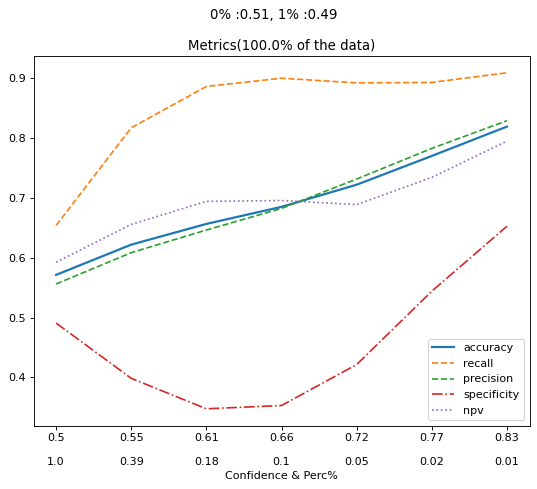

In [15]:
obtain_plot(res, n_original_df = res.shape[0], title = 'Metrics', n_conf = n_conf)

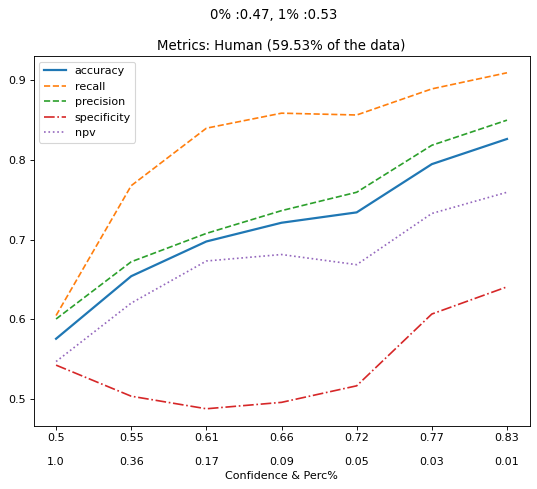

In [16]:
human = res[(res.specie == 'human')]
obtain_plot(human, n_original_df = res.shape[0], title = f'Metrics: Human ', n_conf = n_conf)

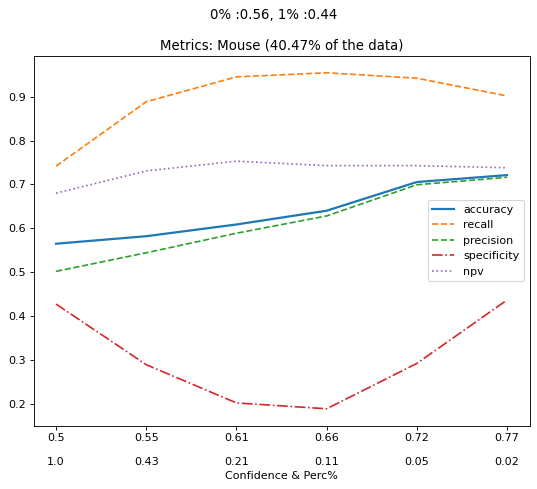

In [17]:
mouse = res[(res.specie == 'mouse')]
obtain_plot(mouse, n_original_df = res.shape[0], title = f'Metrics: Mouse ', n_conf = n_conf)

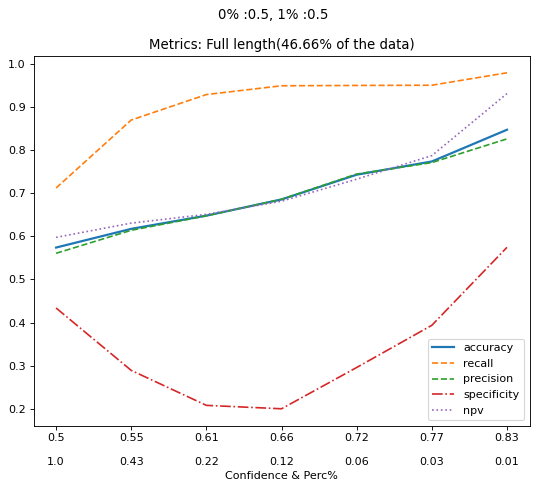

In [18]:
full_length = res[(res.original_length1 <= MAX_RNA_SIZE)&(res.original_length2 <= MAX_RNA_SIZE)]
obtain_plot(full_length, n_original_df = res.shape[0], title = f'Metrics: Full length', n_conf = 10)

In [19]:
confidence_level = 0.66
high_conf_fl = full_length[(full_length.probability>confidence_level)|(full_length.probability<(1-confidence_level))]

In [20]:
(high_conf_fl.ground_truth == high_conf_fl.prediction).sum() / high_conf_fl.shape[0]

0.6819526627218935

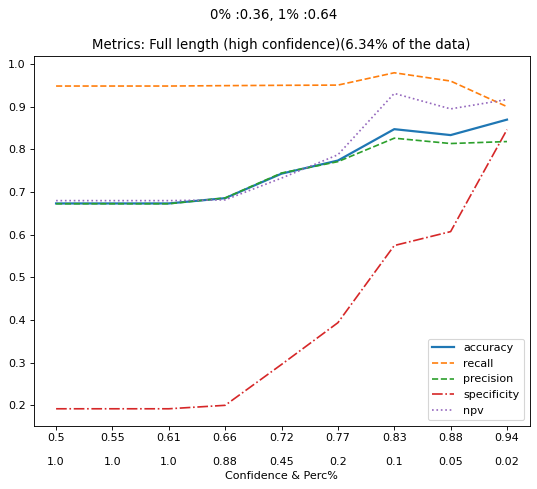

In [21]:
confidence_level = 0.65
high_conf_fl = full_length[(full_length.probability>confidence_level)|(full_length.probability<(1-confidence_level))]
obtain_plot(high_conf_fl, n_original_df = res.shape[0], title = f'Metrics: Full length (high confidence)', n_conf = n_conf)

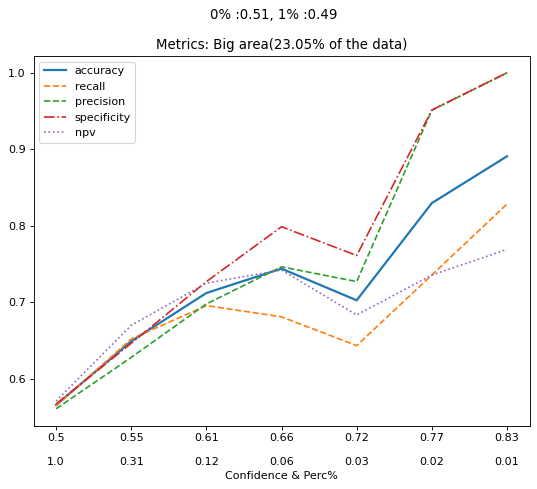

In [22]:
big_area_size = res.sampled_area.quantile(0.8)
big_area_size = 5000**2
big_area = res[res['sampled_area'] > big_area_size]

obtain_plot(big_area, n_original_df = res.shape[0], title = f'Metrics: Big area', n_conf = n_conf)

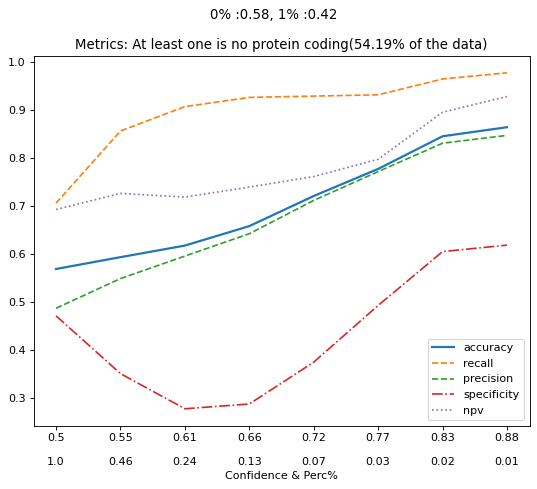

In [23]:
no_pc = res[(res['gene1_pc'] == False)|(res['gene2_pc'] == False)]

obtain_plot(no_pc, n_original_df = res.shape[0], title = f'Metrics: At least one is no protein coding', n_conf = n_conf)

0.5589139586585308


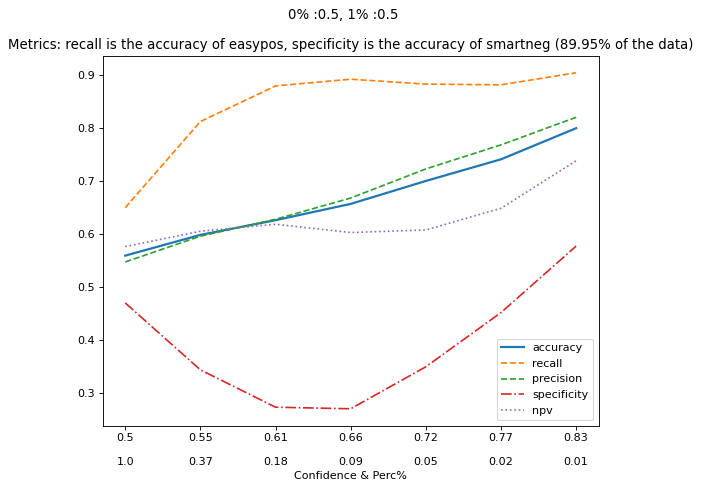

In [44]:
easypos_smartneg = res[(res.policy == 'easypos')|(res.policy == 'smartneg')]
vc = easypos_smartneg.ground_truth.value_counts()
assert vc.loc[1] > vc.loc[0]
n_to_exclude = vc.loc[1] - vc.loc[0]
easypos_gt = easypos_smartneg[easypos_smartneg.ground_truth==1]
id_to_exclude = list(easypos_gt.sample(frac = 1).head(n_to_exclude).id_sample)
easypos_smartneg_sampled = easypos_smartneg[~easypos_smartneg.id_sample.isin(id_to_exclude)]
print((easypos_smartneg_sampled.prediction == easypos_smartneg_sampled.ground_truth).sum()/easypos_smartneg_sampled.shape[0])
obtain_plot(easypos_smartneg_sampled, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg ', n_conf = n_conf)

0.6056782334384858


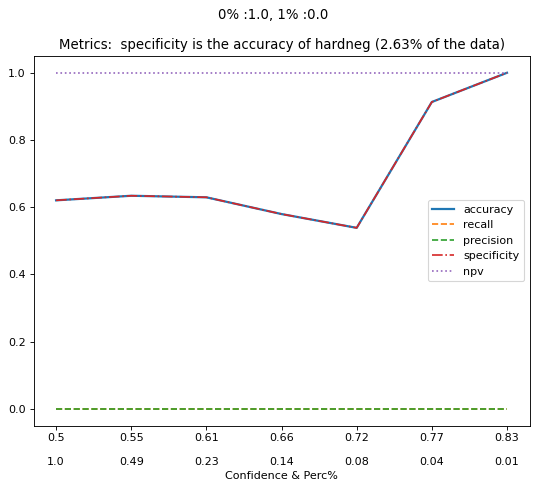

In [45]:
hn = res[(res.policy == 'hardneg')]
print(hn[hn.ground_truth == hn.prediction].shape[0]/easy.shape[0])

obtain_plot(hn, n_original_df = res.shape[0], title = f'Metrics:  specificity is the accuracy of hardneg ', n_conf = n_conf)

0.7160883280757098


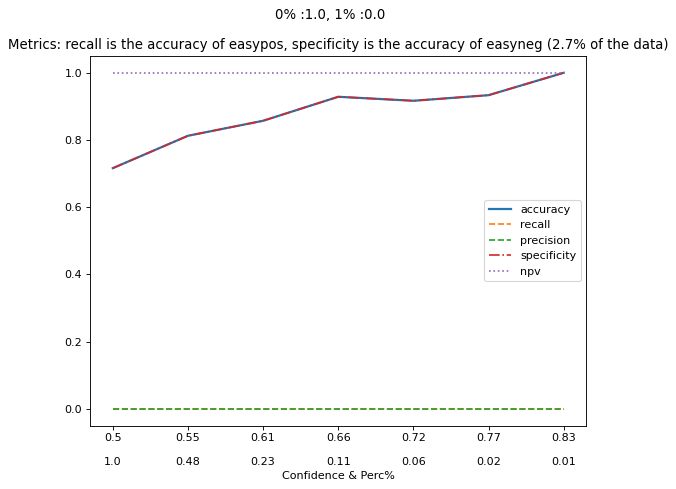

In [25]:
easy = res[(res.policy == 'easyneg')]
print(easy[easy.ground_truth == easy.prediction].shape[0]/easy.shape[0])

obtain_plot(easy, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of easyneg ', n_conf = n_conf)

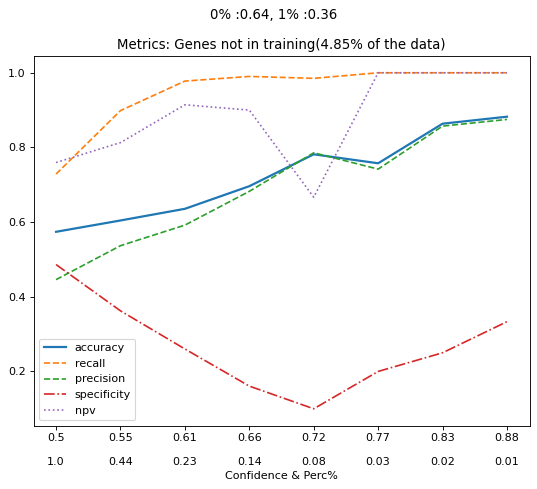

In [55]:
df_train = pd.DataFrame({'couples':gene_pairs_train})
regex = df_train['couples'].str.extractall('(.*)_(.*)_(.*)').reset_index()
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

not_in_train = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]

obtain_plot(not_in_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training', n_conf = n_conf)

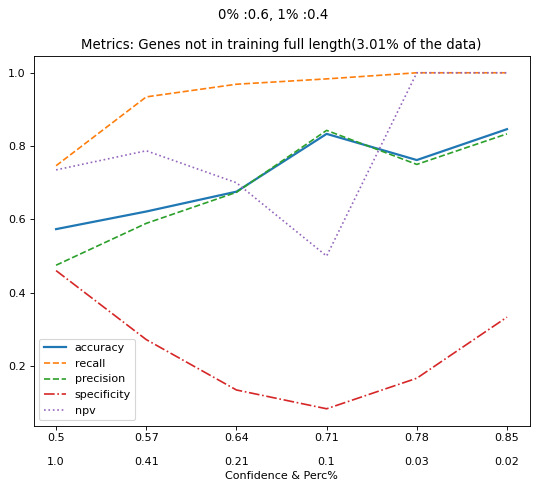

In [56]:
not_in_train_fl = not_in_train[(not_in_train.original_length1 <= MAX_RNA_SIZE)&(not_in_train.original_length2 <= MAX_RNA_SIZE)]
not_in_train_fl = not_in_train_fl[(not_in_train_fl.policy == 'easypos')|(not_in_train_fl.policy == 'smartneg')]
obtain_plot(not_in_train_fl, n_original_df = res.shape[0], title = f'Metrics: Genes not in training full length', n_conf = 8)

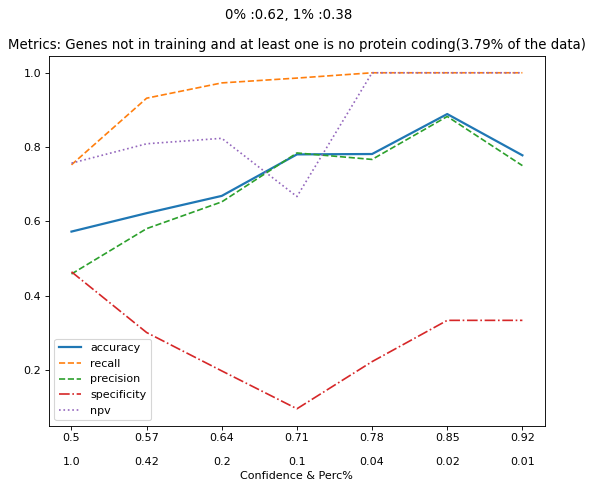

In [57]:
no_pc_no_train = not_in_train[(not_in_train['gene1_pc'] == False)|(not_in_train['gene2_pc'] == False)]

obtain_plot(no_pc_no_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding', n_conf = 8)

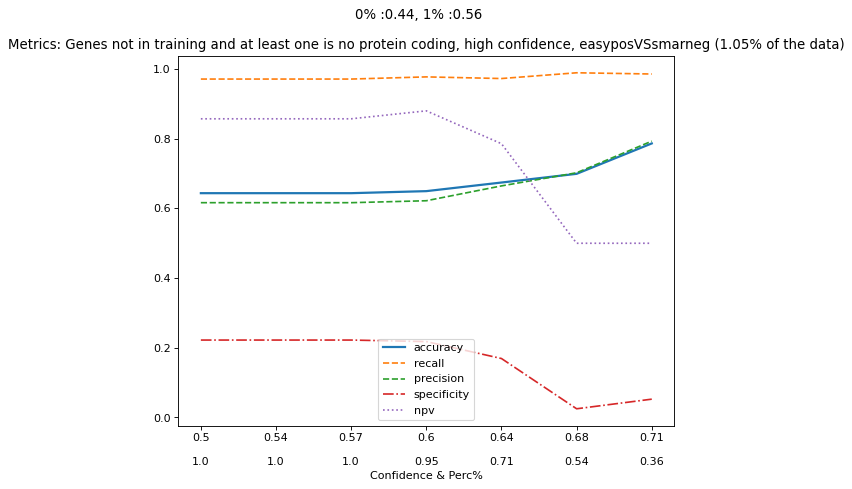

In [60]:
confidence_level = 0.6

no_pc_no_train = not_in_train[(not_in_train['gene1_pc'] == False)|(not_in_train['gene2_pc'] == False)]
no_pc_no_train = no_pc_no_train[(no_pc_no_train.probability>confidence_level)|(no_pc_no_train.probability<(1-confidence_level))]
no_pc_no_train = no_pc_no_train[(no_pc_no_train.policy == 'easypos')|(no_pc_no_train.policy == 'smartneg')]
obtain_plot(no_pc_no_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding, high confidence, easyposVSsmarneg ', n_conf = 15, excluding_treshold = 0.2)

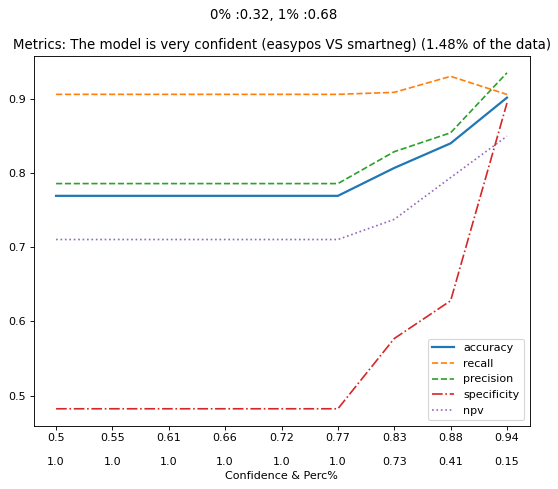

In [67]:
confidence_level = 0.8
high_prob_pairs = res[(res.probability>confidence_level)|(res.probability<(1-confidence_level))]
high_prob_pairs = high_prob_pairs[(high_prob_pairs.policy == 'easypos')|(high_prob_pairs.policy == 'smartneg')]

obtain_plot(high_prob_pairs, n_original_df = res.shape[0], title = f'Metrics: The model is very confident (easypos VS smartneg) ', n_conf = n_conf)

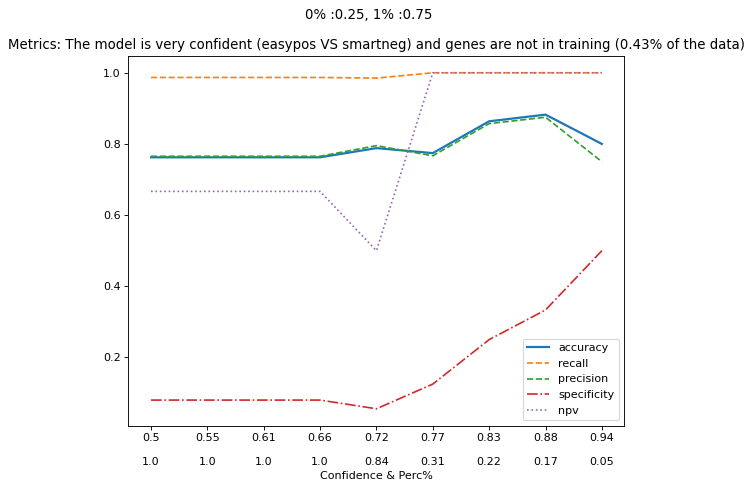

In [69]:
confidence_level = 0.7
high_prob_pairs = not_in_train[(not_in_train.probability>confidence_level)|(not_in_train.probability<(1-confidence_level))]
high_prob_pairs = high_prob_pairs[(high_prob_pairs.policy == 'easypos')|(high_prob_pairs.policy == 'smartneg')]

obtain_plot(high_prob_pairs, n_original_df = res.shape[0], title = f'Metrics: The model is very confident (easypos VS smartneg) and genes are not in training ', n_conf = n_conf)